# Part 4 - Model training

In [1]:
# Loading libraries

import import_ipynb
import SparkLauncher, HDFS
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import lit
import sys
if not sys.warnoptions:
    import warnings
    
    warnings.simplefilter("ignore")
import os
import pyarrow as pa
from pyspark import SparkConf

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import venv_pack
from pyspark.sql.functions import array_contains
import io
from io import StringIO
import pyspark.sql.functions as f
import cv2
import tensorflow
import model
import cvlib as cv
import numpy as np
import pandas as pd

importing Jupyter notebook from SparkLauncher.ipynb
Creating Spark Configuration
importing Jupyter notebook from HDFS.ipynb
importing Jupyter notebook from model.ipynb


Using TensorFlow backend.


In [2]:
#importing additional libraries
import matplotlib
matplotlib.use("Agg")
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from model import SmallerVGGNet
import matplotlib.pyplot as plt
import io
import os
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.applications.mobilenet import decode_predictions
from keras.preprocessing.image import load_img
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [3]:
# loading spark context
spark= SparkLauncher.get_spark_session()
hdfs = HDFS.get_hdfs()

Packing Virtual Environment: msitut1.tar.gz
Setting Environment Variables
Creating Spark Session: msitut1_data603_spark_session


In [4]:
sc=SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [5]:
# Loading our saved parquet file
df_data = spark.read.parquet('/user/msitut1/project_part2.parquet')

In [6]:
df_data.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- LabelName: string (nullable = true)
 |-- Confidence_concat: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Good/Bad: string (nullable = true)
 |-- Target_Label: string (nullable = true)
 |-- Subset: string (nullable = true)
 |-- OriginalURL: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Confidence: string (nullable = true)
 |-- XMin: string (nullable = true)
 |-- XMax: string (nullable = true)
 |-- YMin: string (nullable = true)
 |-- YMax: string (nullable = true)
 |-- IsOccluded: string (nullable = true)
 |-- IsTruncated: string (nullable = true)
 |-- IsGroupOf: string (nullable = true)
 |-- IsDepiction: string (nullable = true)
 |-- IsInside: string (nullable = true)
 |-- chip_data: binary (nullable = true)
 |-- Features: binary (nullable = true)



In [7]:
#Encoding Label-
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
#For Female label value is '0.0' and for Male , label value is '1.0'
df_data=StringIndexer(inputCol="Target_Label", outputCol="Target_Label_Encoded").fit(df_data).transform(df_data)
#https://blogs.ashrithgn.com/basic-encoding-label-encoding-and-one-hot-encoding-in-scala-with-apache-spark/

In [8]:
df_data.limit(5).toPandas()

ImageID            LabelName Confidence_concat    Good/Bad  \
0  001bf60cd96147ea  /m/05r655, /m/0dzct            [1, 1]  Good Image   
1  001bf60cd96147ea  /m/05r655, /m/0dzct            [1, 1]  Good Image   
2  001bf60cd96147ea  /m/05r655, /m/0dzct            [1, 1]  Good Image   
3  001bf60cd96147ea  /m/05r655, /m/0dzct            [1, 1]  Good Image   
4  001bf60cd96147ea  /m/05r655, /m/0dzct            [1, 1]  Good Image   

  Target_Label Subset                                        OriginalURL  \
0       Female  train  https://c3.staticflickr.com/6/5537/12244508303...   
1       Female  train  https://c3.staticflickr.com/6/5537/12244508303...   
2       Female  train  https://c3.staticflickr.com/6/5537/12244508303...   
3       Female  train  https://c3.staticflickr.com/6/5537/12244508303...   
4       Female  train  https://c3.staticflickr.com/6/5537/12244508303...   

      Source Confidence      XMin  ...      YMin      YMax IsOccluded  \
0  activemil          1  0.281250  ...  0.000000  0.728464         -1   
1     xclick          1  0.451250  ...  0.402622  0.489700          0   
2     xclick          1  0.715000  ...  0.370787  0.473783          0   
3     xclick          1  0.571250  ...  0.787453  0.864232          0   
4     xclick          1  0.270000  ...  0.000000  0.999064          1   

  IsTruncated IsGroupOf IsDepiction IsInside  \
0          -1        -1          -1       -1   
1           0         0           0        0   
2           0         0           0        0   
3           0         0           0        0   
4           1         0           0        0   

                                           chip_data  \
0  [255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...   
1  [255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...   
2  [255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...   
3  [255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...   
4  [255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...   

                                            Features Target_Label_Encoded  
0  [255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...                  0.0  
1  [255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...                  0.0  
2  [255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...                  0.0  
3  [255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...                  0.0  
4  [255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0,...                  0.0  

[5 rows x 21 columns]

In [9]:
#reshaping all the images in the same size
def preprocess_image(feature):
    # Load the image
    img = load_img(io.BytesIO(feature), target_size = (224,224))

    # Prepare Image
    image = img_to_array(img)
    image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    return image
    

In [10]:
#Defining data and labels
data=list((df_data.select('Features').toPandas()).Features)
data=[np.array(preprocess_image(i),dtype='float')/255.0 for i in data]
labels=list((df_data.select('Target_Label_Encoded').toPandas()).Target_Label_Encoded)

In [11]:
#Issue found with shape mistmatch , so converting into arrays from list
#https://stackoverflow.com/questions/54005424/keras-imagedatagenerator-problem-with-data-and-label-shape
data=np.array(data)
labels=np.array(labels)

In [12]:
data[0].shape

(224, 224, 3)

In [13]:
labels.shape

(3007,)

In [14]:
from sklearn.model_selection import train_test_split
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,random_state=42,shuffle= True)

In [15]:
len(trainY)

2405

In [16]:
#Converts a class vector (integers) to binary class matrix.
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)


In [17]:
# augmenting datset - ImageDataGenerator will allow us to transform image during training of data,
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")


In [18]:
# initial parameters
epochs = 50
lr = 1e-3
batch_size = 64
img_dims = (224, 224, 3)


In [19]:
# build model
model = SmallerVGGNet.build(width=img_dims[0],height=img_dims[1],depth=img_dims[2],
                            classes=2)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 74, 74, 64)       

In [21]:
# compile the model
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


In [22]:
# train the model
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),steps_per_epoch=len(trainX) // batch_size,epochs=epochs, verbose=1)

Epoch 1/50
37/37 [==============================] - 125s 3s/step - loss: 1.0044 - accuracy: 0.5369 - val_loss: 0.7034 - val_accuracy: 0.5299
Epoch 2/50
37/37 [==============================] - 121s 3s/step - loss: 0.8997 - accuracy: 0.5329 - val_loss: 0.7656 - val_accuracy: 0.5000
Epoch 3/50
37/37 [==============================] - 122s 3s/step - loss: 0.8175 - accuracy: 0.5496 - val_loss: 0.7799 - val_accuracy: 0.4701
Epoch 4/50
37/37 [==============================] - 122s 3s/step - loss: 0.7822 - accuracy: 0.5829 - val_loss: 0.7463 - val_accuracy: 0.4701
Epoch 5/50
37/37 [==============================] - 122s 3s/step - loss: 0.7654 - accuracy: 0.5754 - val_loss: 0.7025 - val_accuracy: 0.5008
Epoch 6/50
37/37 [==============================] - 123s 3s/step - loss: 0.7368 - accuracy: 0.5861 - val_loss: 0.7008 - val_accuracy: 0.5000
Epoch 7/50
37/37 [==============================] - 123s 3s/step - loss: 0.7187 - accuracy: 0.6023 - val_loss: 0.7084 - val_accuracy: 0.4701
Epoch 8/50
37

Received this value mismatch error due to size mismatch in training data 

In [23]:
# plot training/validation loss/accuracy
from keras.utils import plot_model
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig('plot.png')

## Model Evaluation

In [24]:
def predict_label(array_list):
    classes = ['Male','Female']
    conf=array_list
    #print(conf)
    idx=np.where(conf==np.max(conf))[0][0]
    label = classes[idx]
    return idx

In [25]:
#Check how model works
predicted= model.predict(testX)
predicted=[predict_label(i) for i in predicted]
expected =[predict_label(i) for i in testY]


In [26]:
# classification report

print(classification_report(expected,predicted))


              precision    recall  f1-score   support

           0       0.59      0.66      0.62       319
           1       0.56      0.49      0.53       283

    accuracy                           0.58       602
   macro avg       0.58      0.58      0.58       602
weighted avg       0.58      0.58      0.58       602



In [27]:
#Confusion matrix
cm=confusion_matrix(expected, predicted)
cm=cm[::-1,::-1]
print(cm)


[[140 143]
 [109 210]]


#Saving confusion matrix plot in png file and displaying in report

In [28]:
import seaborn as sns
df_cm = pd.DataFrame(cm, columns=np.unique(expected), index = np.unique(expected))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns_plot=sns.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='g',
            yticklabels=['Positive','Negative'],xticklabels=['Positive','Negative'])
sns_plot.figure.savefig("confusion_matrix.png")

In [29]:
tp, fp, fn, tn = cm.ravel()
print("Conclusion - ")
print("True Positives : ",tp,", times observation is positive, and is predicted to be positive")
print("False Negatives: ",fn,", times observation is positive, but is predicted negative.")
print("False Positives: ",fp,", times observation is negative, but is predicted positive.")
print("True Negatives: ",tn,", times observation is negative, and is predicted to be negative.")

Conclusion - 
True Positives :  140 , times observation is positive, and is predicted to be positive
False Negatives:  109 , times observation is positive, but is predicted negative.
False Positives:  143 , times observation is negative, but is predicted positive.
True Negatives:  210 , times observation is negative, and is predicted to be negative.


In [30]:
#Further observations
print("Further conclusions:")
#Total number of prediction
print("Total number of predictions carried out by model:", tp+fp+fn+tn)
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("1. Accuracy:", np.round(Accuracy,2), ", which means", np.round(Accuracy,2) , "% of observations that were predicted by model are correct.")
#Recall
Recall = (tp)*100/(tp+fn)
print("2. Sensitivity:",np.round(Recall,2), ", which means that when model precicts true positives" , np.round(Recall,2), 
      "% of outcomes that were predicted by model are actually true positives.")
#Precision
Precision = (tp)*100 / (tp + fp)
print("3. Exactness:",np.round(Precision,2),", which means that when model precicts true positives," , np.round(Precision,2),
      "% of outcomes that were predicted by model are correct.")


Further conclusions:
Total number of predictions carried out by model: 602
1. Accuracy: 58.14 , which means 58.14 % of observations that were predicted by model are correct.
2. Sensitivity: 56.22 , which means that when model precicts true positives 56.22 % of outcomes that were predicted by model are actually true positives.
3. Exactness: 49.47 , which means that when model precicts true positives, 49.47 % of outcomes that were predicted by model are correct.


# Part - 5 Prediction

In [87]:
#Carrying out predictions

classes = ['Male','Female']
# read input image
image = cv2.imread('images4.jpg')
face, confidence = cv.detect_face(image)
for idx, f in enumerate(face):
    # get corner points of face rectangle       
    (startX, startY) = f[0], f[1]
    (endX, endY) = f[2], f[3]
    
    # draw rectangle over face
    cv2.rectangle(image, (startX,startY), (endX,endY), (0,255,0), 2)
    # crop the detected face region
    face_crop = np.copy(image[startY:endY,startX:endX])
    # preprocessing for gender detection model
    face_crop = cv2.resize(face_crop, (224,224))
    face_crop = face_crop.astype("float") / 255.0
    face_crop = img_to_array(face_crop)

    face_crop = np.expand_dims(face_crop, axis=0)
    #print(face_crop.shape)
    # apply gender detection on face
    pred= model.predict(face_crop)
    ##print(pred)
    conf=pred[0]
    #print(conf)
    # get label with max accuracy
    idx = np.where(conf==np.max(conf))[0][0]
    label = classes[idx]
    label = "{}: {:.2f}%".format(label, conf[idx] * 100)
    #print(label)
    #print(startY)
    Y = startY - 10 if startY - 10 > 10 else startY + 10
    #print(Y)   
    #write label and confidence above face rectangle
    cv2.putText(image, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)
from PIL import Image

# display output
#print(image)
display(Image.fromarray(image))

In [91]:
#Carrying out predictions

def prediction(image_file):
    classes = ['Male','Female']
    # read input image
    image = cv2.imread(image_file)
    face, confidence = cv.detect_face(image)
    #print(face)
    for idx, f in enumerate(face):
        # get corner points of face rectangle       
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]

        # draw rectangle over face
        cv2.rectangle(image, (startX,startY), (endX,endY), (0,255,0), 2)
        # crop the detected face region
        face_crop = np.copy(image[startY:endY,startX:endX])
        # preprocessing for gender detection model
        face_crop = cv2.resize(face_crop, (224,224))
        face_crop = face_crop.astype("float") / 255.0
        face_crop = img_to_array(face_crop)

        face_crop = np.expand_dims(face_crop, axis=0)
        #print(face_crop.shape)
        # apply gender detection on face
        conf = model.predict(face_crop)[0]
        #print(conf)
        #print(np.where(conf==np.max(conf))[0][0])
        # get label with max accuracy
        idx = np.where(conf==np.max(conf))[0][0]
        label = classes[idx]
        label = "{}: {:.2f}%".format(label, conf[idx] * 100)
        print(label)
        #print(startY)
        Y = startY - 10 if startY - 10 > 10 else startY + 10
        #print(Y)   
        #write label and confidence above face rectangle
        cv2.putText(image, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)
        from PIL import Image

    # display output
    #print(image)
    display(Image.fromarray(image))
    return

Male: 92.37%


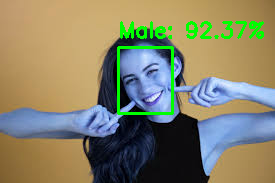

Male: 100.00%


Male: 100.00%
Male: 100.00%


Male: 99.54%


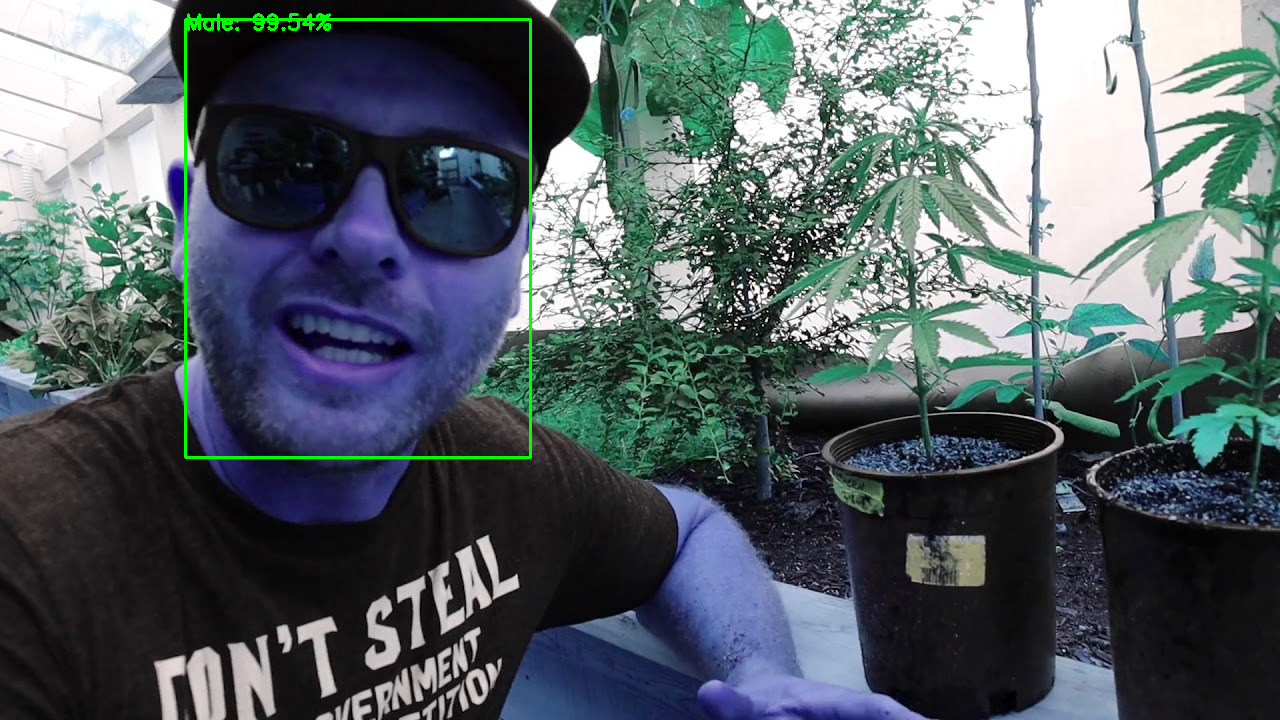

Male: 100.00%
Male: 100.00%


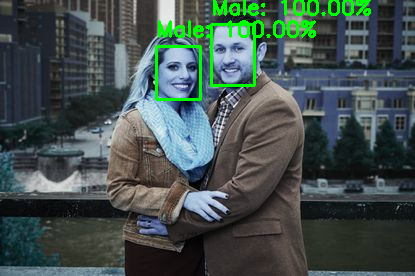

In [92]:
for i in range(1,6):
    prediction('images'+str(i)+'.jpg')

So our model is succesfully able to predict Male faces but unable to predict female faces . This might be because we have trained our model with 150 images of male and female. Because we tried to run 50 epochs but validation and accuracy graph shows not much of a improvement in accuracy of validation set. 

We can achieve better aacuracy if we increase the sample input consisting of image ids of male and female faces from 150 to more and train our model.


In [ ]:
spark.catalog.clearCache()
sqlContext.clearCache()

In [ ]:
spark.stop()